Connected to llm_research (Python 3.11.4)

In [1]:
# simplified version of the above code
# simple autorergressive transformer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt

dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


torch.set_default_tensor_type(torch.cuda.FloatTensor)

to_nearest_64 = lambda x: round(x/64) * 64
model_scale = 1.
max_seq_len = 100

qk_dim_div = 8
expand_factor = 2
residual_depth = to_nearest_64(384 * math.log2(1.+model_scale))

num_blocks = round(8 * math.log2(1.+model_scale))
causal_mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()

with torch.no_grad():
  bias_range = torch.arange(-max_seq_len+1, 1).to(device, dtype)
  position_bias_base = bias_range.unsqueeze(0) - bias_range.unsqueeze(1)
  negative_infinity_matrix_base = torch.empty_like(position_bias_base).fill_(-float("inf"))
  causal_mask = torch.tril(torch.ones((max_seq_len, max_seq_len), device=device, dtype=torch.bool))

/home/service/miniconda3/envs/llm_research/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
class LatentAttentionBlock(nn.Module):
  """ Efficient fused latent-space attention block. Linear keys and queries, nonlinear values."""
  def __init__(self, num_dim):
    super().__init__()

    self.dim        = num_dim
    self.qk_dim     = self.dim//qk_dim_div
    self.v_dim      = num_dim
    self.expand_dim = num_dim * expand_factor

    self.norm       = nn.LayerNorm(self.dim, bias=False)
    self.expand     = nn.Parameter(.5 * 1./residual_depth**.5 * 1./expand_factor * torch.randn(2*self.qk_dim+2*self.expand_dim, self.dim))
    self.project    = nn.Parameter(1. * 1./residual_depth**.5 * 1./expand_factor * 1./num_blocks * torch.randn((self.dim, self.expand_dim),dtype=dtype))
    self.position_bias_mult = nn.Parameter(torch.tensor(1.))

  def forward(self, x):
    residual = x
    attn_mask = torch.where(causal_mask[:x.shape[1], :x.shape[1]], F.softplus(self.position_bias_mult) * position_bias_base[:x.shape[1], :x.shape[1]], negative_infinity_matrix_base[:x.shape[1], :x.shape[1]])
    x = self.norm(x)
    query, key, linear, pre_gelu = F.linear(x, self.expand).split((self.qk_dim, self.qk_dim, self.expand_dim, self.expand_dim), dim=-1)
    geglu = linear * F.gelu(pre_gelu)
    geglu_local, geglu_attention_value = geglu.split((self.expand_dim-self.v_dim, self.v_dim), -1)
    attention = F.scaled_dot_product_attention(query, key, geglu_attention_value, attn_mask=attn_mask)
    out = F.linear(torch.cat([geglu_local, attention], dim=-1), self.project)
    x = residual + out
    return x
   
n_toks = 100

In [3]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(n_toks, residual_depth, scale_grad_by_freq=True)
    self.blocks = nn.ModuleList([LatentAttentionBlock(residual_depth) for _ in range(num_blocks)])
    self.norm = nn.LayerNorm(residual_depth, bias=False)
    self.out = nn.Linear(residual_depth, n_toks, bias=False)
  
  def forward(self, x):
    x = self.emb(x)
    x = self.norm(x)
    for block in self.blocks: x = block(x)
    x = self.norm(x)
    x = self.out(x)
    return x

In [4]:
net = Model().to(device, dtype).train()
opt = optim.Adam(net.parameters(), lr=3e-4)

def gen_data(n):

  y = torch.arange(max_seq_len)
  fs = (torch.randint(0,1000,(n,1))/1000)
  y = torch.sin(y.reshape(1, -1) * fs + torch.randn(n,1) * 2)
  y = (y - y.min()) / (y.max() - y.min()) * (n_toks-1)
  y = torch.cat([torch.zeros(n,1),y], dim=1).long()
  x = y[:, :-1]
  y = y[:, 1:]
  return x,y

def step(x,y):
  opt.zero_grad()
  out = net(x)
  loss = F.cross_entropy(out[:,2:].reshape(-1, n_toks),y[:,2:].flatten())
  loss.backward()
  opt.step()
  return loss

/home/service/miniconda3/envs/llm_research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
epochs = 1000
for _ in range(10):
  x,y = gen_data(100)
  for _ in range(epochs // 10):
    l = step(x,y)
  print(l)

tensor(1.8904, grad_fn=<NllLossBackward0>)
tensor(0.7261, grad_fn=<NllLossBackward0>)
tensor(0.4732, grad_fn=<NllLossBackward0>)
tensor(0.2911, grad_fn=<NllLossBackward0>)
tensor(0.1856, grad_fn=<NllLossBackward0>)
tensor(0.1772, grad_fn=<NllLossBackward0>)
tensor(0.1356, grad_fn=<NllLossBackward0>)
tensor(0.1113, grad_fn=<NllLossBackward0>)
tensor(0.1016, grad_fn=<NllLossBackward0>)
tensor(0.0913, grad_fn=<NllLossBackward0>)


******* TEST *******


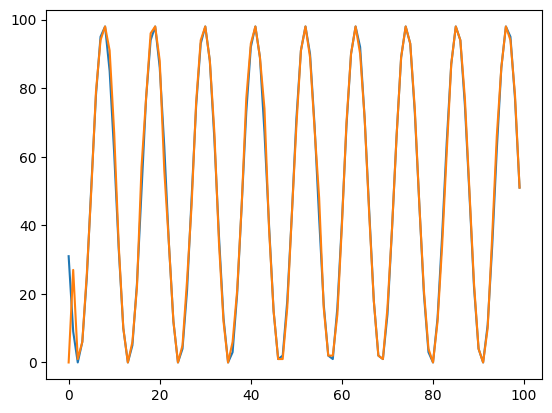

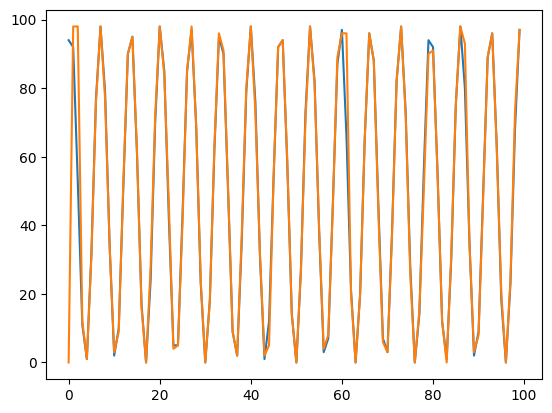

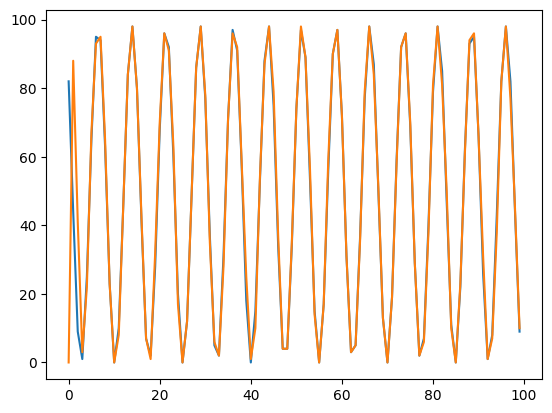

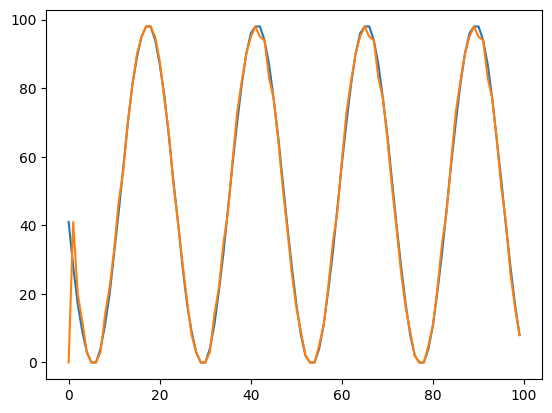

In [6]:
print("******* TEST *******")
x,y = gen_data(100)
p = net(x)
for i in range(4):
  plt.plot(y[i,:].cpu().detach())
  plt.plot(p[i,:].argmax(1).cpu().detach())
  # plt.imshow
  plt.show()

******* INFERENCE ********


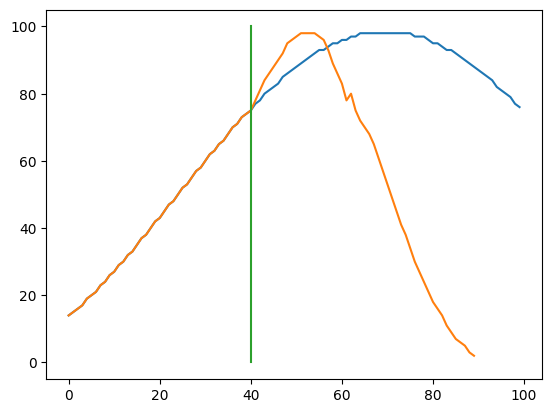

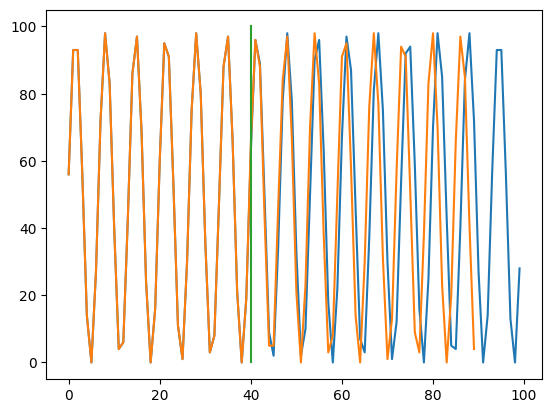

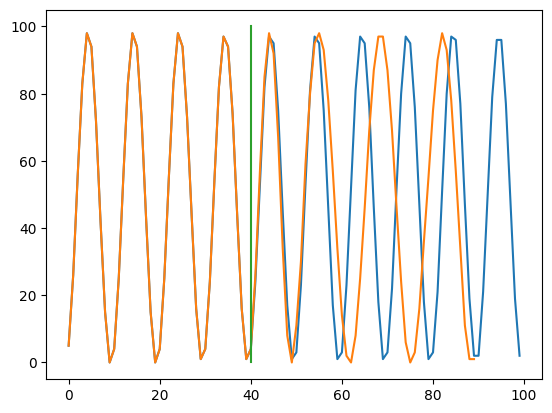

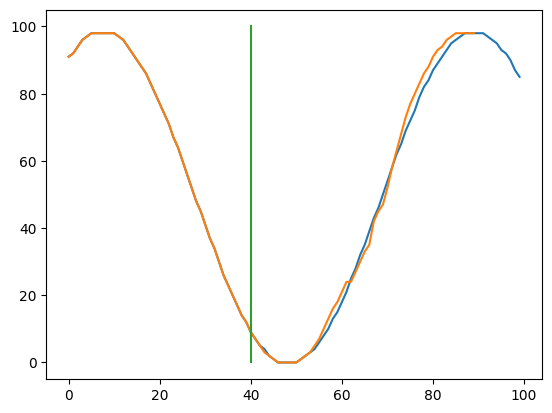

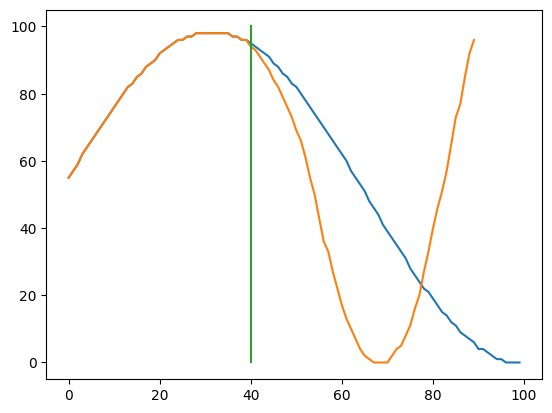

In [7]:
print ("******* INFERENCE ********")
ww = 40

def generate(n):
  x,y = gen_data(100)
  x = y[:1,0:ww]
  for i in range(n):
    p = net(x[:,-99:])
    choices = p[0,-1,:]
    choice = torch.multinomial(choices.softmax(-1), 1)
    x = torch.cat([x, choice.reshape(1,1)], dim=1)
  return x, y

for i in range(5):
  p,y = generate(50)
  plt.plot(y[0,:].cpu().numpy())
  plt.plot(p[0,:].cpu().numpy())
  plt.plot([ww,ww],[0,100])
  plt.show()

******* INFERENCE ********


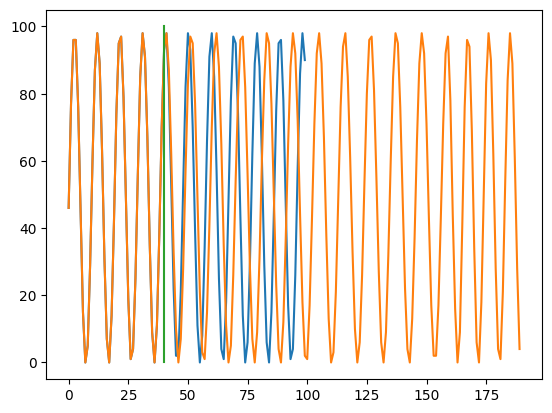

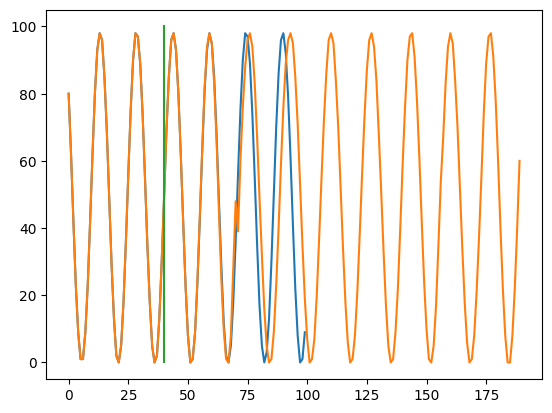

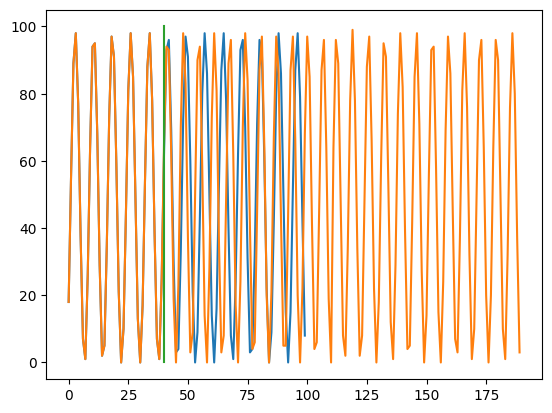

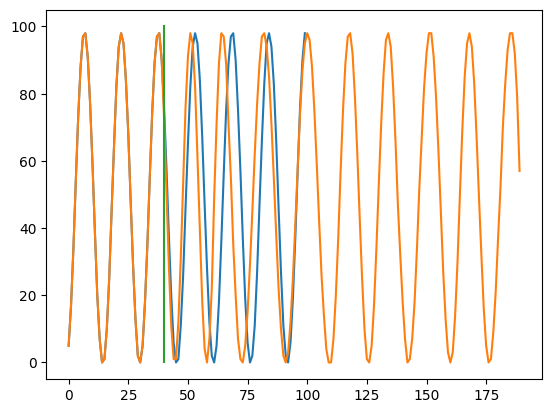

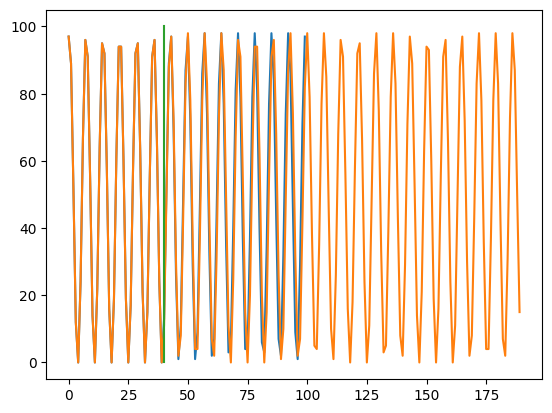

In [8]:
print ("******* INFERENCE ********")
ww = 40

def generate(n):
  x,y = gen_data(100)
  x = y[:1,0:ww]
  for i in range(n):
    p = net(x[:,-99:])
    choices = p[0,-1,:]
    choice = torch.multinomial(choices.softmax(-1), 1)
    x = torch.cat([x, choice.reshape(1,1)], dim=1)
  return x, y

for i in range(5):
  p,y = generate(150)
  plt.plot(y[0,:].cpu().numpy())
  plt.plot(p[0,:].cpu().numpy())
  plt.plot([ww,ww],[0,100])
  plt.show()

******* INFERENCE ********


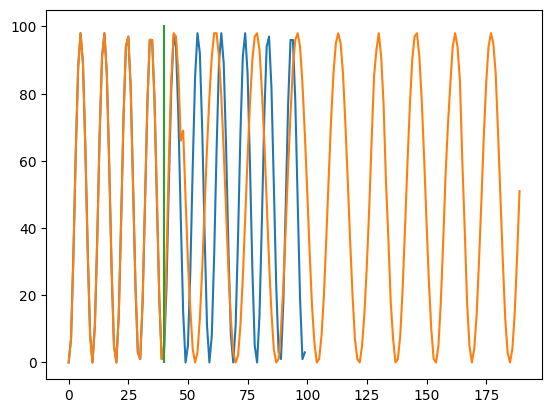

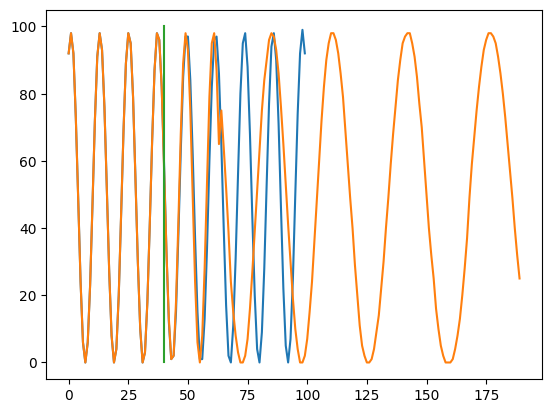

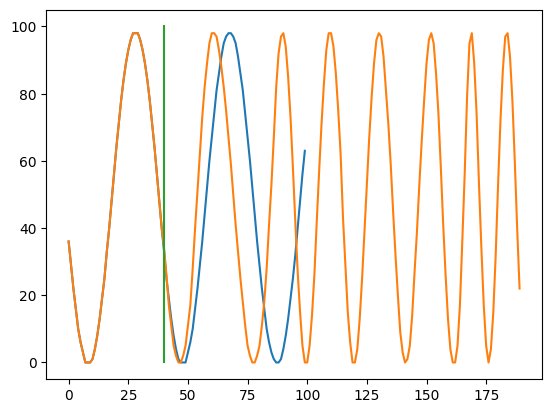

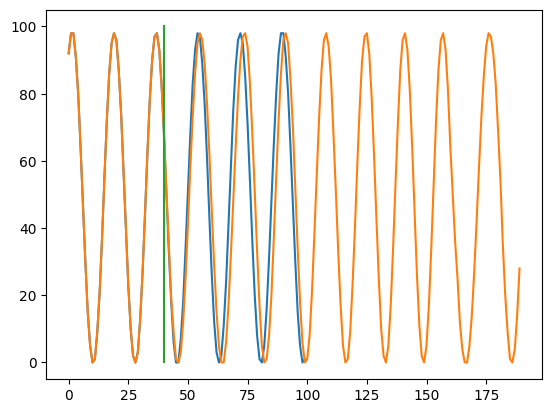

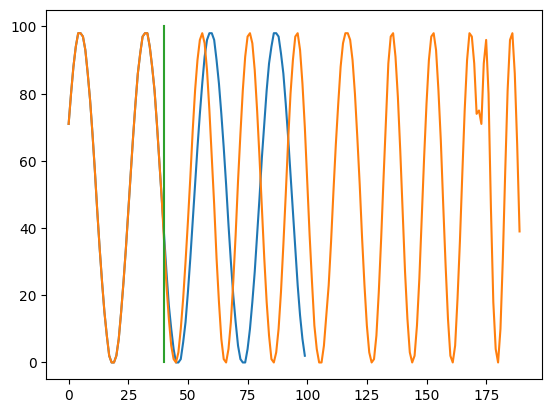

In [9]:
print ("******* INFERENCE ********")
ww = 40

def generate(n):
  x,y = gen_data(100)
  x = y[:1,0:ww]
  for i in range(n):
    p = net(x[:,-99:])
    choices = p[0,-1,:]
    choice = torch.multinomial(choices.softmax(-1), 1)
    x = torch.cat([x, choice.reshape(1,1)], dim=1)
  return x, y

for i in range(5):
  p,y = generate(150)
  plt.plot(y[0,:].cpu().numpy())
  plt.plot(p[0,:].cpu().numpy())
  plt.plot([ww,ww],[0,100])
  plt.show()